<a href="https://colab.research.google.com/github/Teoroo-CMC/DoE_Course_Material/blob/main/Week_2/Lab_1/Task_2/opt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab: find optimum

In [32]:
#Import all packages
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
from numpy.random import rand
import itertools
from matplotlib.pyplot import *
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf


## Experiment
This part defines you experiment. To get data from your experimental setup, just 

```python 
gaussian_function=(x, y, fwhm)
```

which will give you you result 

In [33]:
# Data generation. Doo not touch... This is your physical space :) 

def gaussian_function(x, y, pars=None, add_noise=False):
    # to be changed: genereate all data here
    np.random.seed(2)
    if not pars:
        x0 = np.random.randn(1)[0]+0.5
        y0 = x0+0.5
        fwhm = np.random.normal(loc=1.5,scale=3, size=100).mean()
    else:
        x0, y0, fwhm = pars
        
    func = 10*np.exp(-4*np.log(2) * ((x-x0)**2 + (y-y0)**2) / fwhm**2)
    
    if add_noise:
        func = add_noise_func(func)
    
    return func, x0, y0, fwhm

def add_noise_func(input_data, mean_noise=0):
    # incomplete: refactor code to generate data + noise in one function
    avg_data = np.mean(input_data)
    noise_ = np.random.normal(mean_noise, np.sqrt(avg_data), 1)[0]
    output_data = input_data + noise_
    
    return output_data



This is how you call for experimental data at x=1 and y=1: 

In [34]:
gaussian_function(1,1)[0]

1.5879227876724087

Use DoE and factioral design to locate the maxima. 

To start the experiment, a 2x2 2^2 DoE between -2 and +2 will be done.

In [35]:
# create dictionary for parameters, start parameters from -2 to 2, with centerpoint
input_labels = {'A' : 'x1',
                 'B' : 'x2'}

#Where x1 and x2 are the 2 imput variables for the fuction

#create list of data for high and low. 
data = [('A',0,0.25,0.5),
        ('B',0,0.25,0.5)]

# create pandas dataframe in a pandas dataframe
inputs_df = pd.DataFrame(data,columns=['index', 'low','center', 'high'])
inputs_df = inputs_df.set_index(['index'])
inputs_df['label'] = inputs_df.index.map( lambda z : input_labels[z] )

#print dataframe hig and low
inputs_df

,low,center,high,label
index,,,,
A,0,0.25,0.5,x1
B,0,0.25,0.5,x2


In [36]:
# compute averages and span
inputs_df['average'] = inputs_df.apply( lambda z : ( z['high'] + z['low'])/2, axis=1)
inputs_df['span'] = inputs_df.apply( lambda z : ( z['high'] - z['low'])/2, axis=1)

# encode the data
inputs_df['encoded_low'] = inputs_df.apply( lambda z : ( z['low']  - z['average'] )/( z['span'] ), axis=1)
inputs_df['encoded_center'] = inputs_df.apply( lambda z : ( z['center'] - z['average'] )/( z['span'] ), axis=1)
inputs_df['encoded_high'] = inputs_df.apply( lambda z : ( z['high'] - z['average'] )/( z['span'] ), axis=1)

inputs_df = inputs_df.drop(['average','span'],axis=1)

inputs_df

,low,center,high,label,encoded_low,encoded_center,encoded_high
index,,,,,,,
A,0,0.25,0.5,x1,-1.0,0.0,1.0
B,0,0.25,0.5,x2,-1.0,0.0,1.0


In [37]:
#Create the design matrix

encoded_inputs= list(itertools.product([-1,1],[-1,1]))
encoded_inputs.append((0,0))

#for i in range(0,5):
#    encoded_inputs.append((0,0))
#encoded_inputs

results=pd.DataFrame(encoded_inputs)
#results=results[results.columns[::-1]]
results.columns=['A','B']

results

,A,B
0,-1,-1
1,-1,1
2,1,-1
3,1,1
4,0,0


In [38]:
#Calculate the experiment matrix 

real_experiment = results

var_labels = []
for var in ['A','B']:
    var_label = inputs_df.loc[var]['label']
    var_labels.append(var_label)
    real_experiment[var_label] = results.apply(
        lambda z : inputs_df.loc[var]['low'] if z[var]<0 else (inputs_df.loc[var]['high'] if z[var]>0 else inputs_df.loc[var]['center']), 
        axis=1)

print("The values of each real variable in the experiment are:")
real_experiment[var_labels]

The values of each real variable in the experiment are:


,x1,x2
0,0.00,0.00
1,0.00,0.50
2,0.50,0.00
3,0.50,0.50
4,0.25,0.25


In [39]:
#Use the function to obtain experimental values, loop over x1 and x2

y=[]

for i in range(0,len(real_experiment)): 
    y.append(gaussian_function(real_experiment['x1'][i], real_experiment['x2'][i])[0])
    
results['Response'] = y

results


,A,B,x1,x2,Response
0,-1,-1,0.00,0.00,5.326879
1,-1,1,0.00,0.50,9.751671
2,1,-1,0.50,0.00,3.936062
3,1,1,0.50,0.50,7.205567
4,0,0,0.25,0.25,7.772751


In [47]:
#Compute main and twoway effects. 

#Main effects
labels = ['A','B']

main_effects = {}

for key in labels:
        average_effects = results.groupby(key)['Response'].mean()
        main_effects[key] = sum( [i*average_effects[i] for i in [-1,1]])


#Two-way effects
twoway_labels = list(itertools.combinations(labels, 2))


twoway_effects = {}
for key in twoway_labels:
    
    effects = results.groupby([key[0],key[1]])['Response'].mean()
    
    twoway_effects[key] = sum([ i*j*effects[i][j]/2 for i in [-1,1] for j in [-1,1] ])
twoway_effects

#Display the effects in a pd df
effects=[] #pd.DataFrame({})
indexes=[]
for i,k in enumerate(main_effects.keys()):
    effects.append(abs(main_effects[k]))
    indexes.append(k)
for i,k in enumerate(twoway_effects.keys()):
    effects.append(abs(twoway_effects[k]))
    indexes.append(k) 
    
effects_df=pd.DataFrame({"Standardized effect":effects})

# reset the indexes
effects_df.index=indexes
# Sort values in descending order
effects_df = effects_df.sort_values(by='Standardized effect', ascending=False)
# Add cumulative percentage column, shows the relative impotance of the parameters
effects_df["cum_percentage"] = round(effects_df["Standardized effect"].cumsum()/effects_df["Standardized effect"].sum()*100,2)

# Display data frame with effects
effects_df

,Standardized effect,cum_percentage
B,3.847148,60.18
A,1.968460,90.96
"(A, B)",0.577643,100.00


From this B (60%) is seen to be more imporatnt than A (30%) and A-B (10%). A-B is thus excluded. 

In [41]:
s = "y_hat = "

s += "%0.8f "%(results['Response'].mean())

for i,k in enumerate(main_effects.keys()):
    if(main_effects[k]<0):
        s += "%0.8f %s "%(main_effects[k]/2.0, k )
    else:
        s += "+ %0.8f %s "%(main_effects[k]/2.0, k )

for i,k in enumerate(twoway_effects.keys()):
    if(twoway_effects[k]<0):
        s += " %0.8f %s %s"%( twoway_effects[k]/2.0, k[0],k[1])
    else:
        s += "+ %0.8f %s %s"%( twoway_effects[k]/2.0, k[0],k[1])



print(s)

y_hat = 6.79858603 -0.98423010 A + 1.92357394 B  -0.28882173 A B


In [48]:
#Automated OLS, gives the same information. 

y1 = results['Response']
xlabs=['A','B']
#x = results[xlabs]
#x = sm.add_constant(x)

res1 = smf.ols(formula='Response ~ A + B + I(t**2)', data=results).fit()   #ordinary least square

res1.summary()


/home/aleul811/.local/lib/python3.10/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Response   R-squared:                       0.925
Model:                            OLS   Adj. R-squared:                  0.849
Method:                 Least Squares   F-statistic:                     12.29
Date:                Wed, 14 Jun 2023   Prob (F-statistic):             0.0753
Time:                        09:39:46   Log-Likelihood:                -4.1177
No. Observations:                   5   AIC:                             14.24
Df Residuals:                       2   BIC:                             13.06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.7986      0.390     17.438      0.003       5.121       8.476
A             -0.9842      0.436     -2.258      0.152      -2.860       0.891
B              1.9236      0.436      4.413      0.048       0.048       3.799
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   1.932
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.563
Skew:                           0.743   Prob(JB):                        0.754
Kurtosis:                       2.297   Cond. No.                         1.12
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The function that fits the data is: 

y_hat = 6.79858603 -0.98423010 A + 1.92357394 B  -0.28882173 A B

Now the task is to find the maxima of this function. 

##HOW??## I feel like it is here im going wrong 
#Can we neglect the common term?

In [43]:
# Method of steepest acent.

# If we move 0.00005848 in the direction of A and 0.00010824 in the direction of B, 
# this will be the steepest acend in the box of experiments. 
#Lets do it in steps of B=0.1 gives steps of A=0.005

#B = 0.1
#A = (0.1*0.00005848)/0.00010824



In [68]:
# Calculate x1 and x2, run the function over these values 

#Calculate delta in the direction of the steepest acent
#y = 6.7986 - 0.9842 A + 1.9236 B
#A/-0.9842 = B/1.9236
#A=1
B = (1/-0.9842)*1.9236

Origin = [0,0] 
delta= [0.1,0.5]
march=[(0,0)]


for i in range(0,10):
    march.append((Origin[0]+(i+1)*delta[0],Origin[1]+(i+1)*delta[1])) 

March=pd.DataFrame(march, columns=['x1', 'x2'])


# Define the function of the first testing square, DoE_1

#def DoE_1(A, B):
#    return 1.06546247 + (0.00005848*A) + (0.00010824*B) + (0.00005845*A*B)

#response_for_march_df = []

#for i in range(0, len(March)):
 #   response_for_march_df.append(DoE_1(, March[i]))



March['New_responses_y_hat_1'] = March.apply(lambda row : 6.7986 - (0.9842*row[0]) + (1.9236*row[1]), axis=1)


March



,x1,x2,New_responses_y_hat_1
0,0.0,0.0,6.79860
1,0.1,0.5,7.66198
2,0.2,1.0,8.52536
3,0.3,1.5,9.38874
4,0.4,2.0,10.25212
5,0.5,2.5,11.11550
6,0.6,3.0,11.97888
7,0.7,3.5,12.84226
8,0.8,4.0,13.70564
9,0.9,4.5,14.56902


Text(0, 0.5, 'Response')

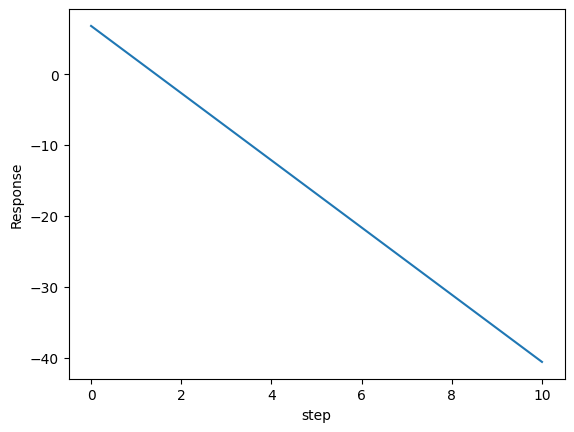

In [63]:
ax=March['New_responses_y_hat_1'].plot()
ax.set_xlabel("step")
ax.set_ylabel("Response")

In [46]:
#Gör en funktion från dessa
#uppskatta maxima
#Gör en linjär testning tills du hittar typ ett maxima
#Gör ett nytt DoE kring ett approximativt maxima 
#Gör en polynom anpassning för att hitta maximat i den nya DoE rutan 